In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from google.colab import drive
from scipy import optimize
import os

In [2]:
#Mount gdrive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Obtain list of files from scattering folder
os.chdir("/content/gdrive/MyDrive/PHY 445/Data/Scattering/Energy_angle_relation/")
back_list = os.listdir("background/")
scat_list  = os.listdir("scattering/")

In [4]:
# Define a function to extract data from a file
def extract_data(file_path):
  data = []

  with open(file_path, 'r') as file:
    next(file)
    next(file)
    next(file)
    next(file)

    for line in file:
      if not line.strip():
        continue

      else:
        line = line.strip().split()
        line = [float(line[i]) for i in range(1,len(line))]
        data = data + line

  counts  = np.array(data)

  return counts

In [5]:
# Define calibration
calib = [1.38, -58.7]

# Define function to convert bins to E
def B_E(x, Bin_to_E = calib):
  return Bin_to_E[0]*x + Bin_to_E[1]

In [6]:
# Create list of angles and extract background and scattering data
back_angles = []
scat_angles = []

back_data = []
scat_data = []
for element in back_list:
  back_angles.append(int(element[5:].split(".")[0]))
  back_data.append(extract_data("background/" + element))

for element in scat_list:
  scat_angles.append(int(element[5:].split(".")[0]))
  scat_data.append(extract_data("scattering/" + element))

if back_angles != scat_angles:
  print("One or more background or scattering files missing")

else:
  angles = np.array(back_angles)

In [7]:
#Correct data for detection efficiency
def eps(x, p_0, p_1, Bin_to_E = calib):
  x = Bin_to_E[0]*x + Bin_to_E[1]
  epsilon = p_0[1]*(x/p_0[0])**(np.log(p_1[1]/p_0[1])/np.log(p_1[0]/p_0[0]))
  return epsilon
a = 0
b = 0
epsilon = eps(np.arange(2048), [0.01,0.08*np.exp(a)], [1.414,0.005*np.exp(b)])

<ipython-input-7-5f7364f9b755>:4: RuntimeWarning: invalid value encountered in power
  epsilon = p_0[1]*(x/p_0[0])**(np.log(p_1[1]/p_0[1])/np.log(p_1[0]/p_0[0]))


Text(0, 0.5, 'Epsilon (efficiency)')

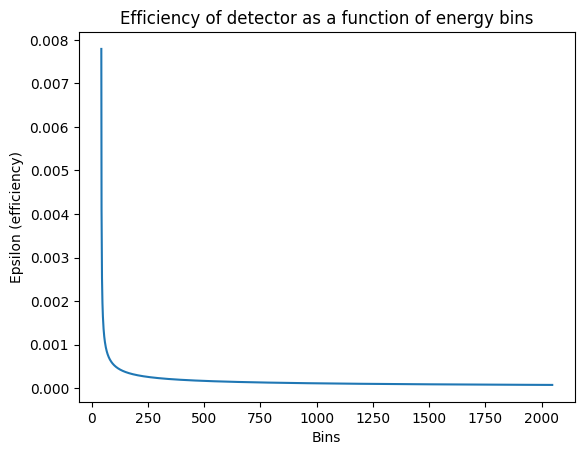

In [8]:
plt.plot(range(len(epsilon)), epsilon)
plt.title("Efficiency of detector as a function of energy bins")
plt.xlabel('Bins')
plt.ylabel('Epsilon (efficiency)')

In [9]:
# Obtain scattering data by subtracting background
data = [(scat_data[i] - back_data[i])/epsilon for i in range(len(angles))]
sigmas = [(scat_data[i] + back_data[i])**0.5/epsilon for i in range(len(angles))]

In [10]:
#Remove NaNs from data
for i in range(len(angles)):
  data[i][np.isnan(data[i])] = 1
  sigmas[i][np.isnan(sigmas[i])] = 1

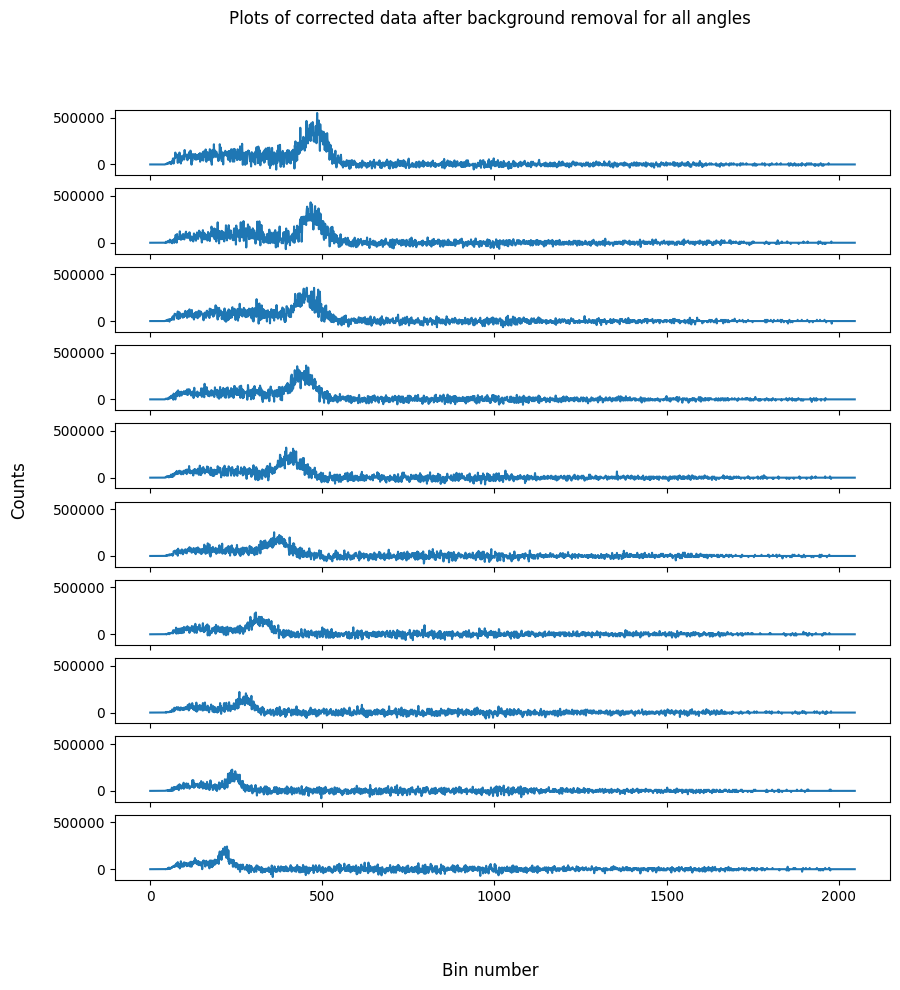

In [11]:
# Plot corrected scattering data
x = range(len(data[0]))
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10) = plt.subplots(10, sharex = True, sharey = True)
fig.suptitle("Plots of corrected data after background removal for all angles")
fig.supxlabel("Bin number")
fig.supylabel("Counts")
ax1.plot(x, data[0])
ax2.plot(x, data[1])
ax3.plot(x, data[2])
ax4.plot(x, data[3])
ax5.plot(x, data[4])
ax6.plot(x, data[5])
ax7.plot(x, data[6])
ax8.plot(x, data[7])
ax9.plot(x, data[8])
ax10.plot(x, data[9])
fig.set_size_inches(10, 10)
plt.show()

Text(0, 0.5, 'Counts')

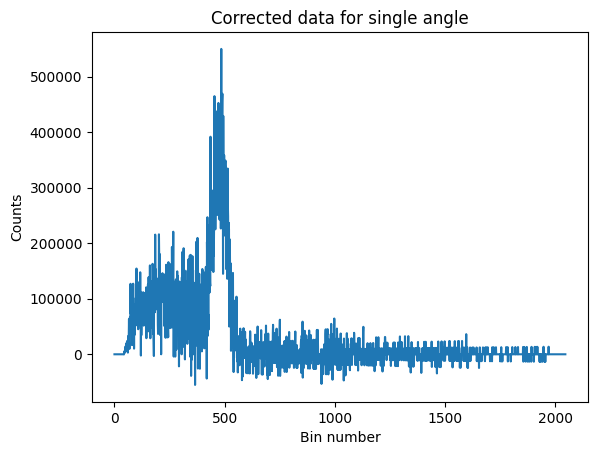

In [12]:
plt.plot(x, data[0])
plt.title("Corrected data for single angle")
plt.xlabel("Bin number")
plt.ylabel("Counts")

In [13]:
# Define appropriate curve to fit
def gaussian(x, mu, std, h):
  return h*np.exp(-(x-mu)**2/(2*std**2))

def exponential(x, a, b):
  return a*np.exp(-b*x)

def poly(x, a1, a2, a3):
  return a1 + a2*x + a3*x**2

def fit_func(x, mu1,mu2, std1,std2, h1,h2):
  return gaussian(x,mu1,std1,h1) + gaussian(x,mu2,std2,h2)

In [14]:
# Create a list of guesses for the location of the peaks
def guess(init_guess, bin_to_E, angles):
  E_0 = 1/((1/init_guess) - (1 - np.cos(angles[0]*np.pi/180))*bin_to_E/511)
  return 1/((1/E_0) + (bin_to_E/511)*(1 - np.cos(np.pi*angles/180)))

guesses = guess(500, 1.32, angles)

In [15]:
# Use guesses to fit appropriate curve
i = 0
coefficients  = []
covariances = []
for guess in guesses:
  popt, pcov = scipy.optimize.curve_fit(fit_func, np.arange(2048), data[i], p0 = [100,guess,5,1,80,80], sigma = 1 + sigmas[i], absolute_sigma = True)
  coefficients.append(popt)
  covariances.append(pcov)
  i = i + 1

In [16]:
coefficients[0][3]

37.94283685567057

In [17]:
#Extract list of energy peaks
E = [coeff[1] for coeff in coefficients]
#sigma_E = [var[1,1]**0.5 for var in covariances]
sigma_E = [coeff[3] for coeff in coefficients]

In [18]:
# Define equation
def compton(theta, E_0, m, Bin_to_E = calib):
  return 1/((Bin_to_E[0]/E_0) + (Bin_to_E[0]/m)*(1-np.cos(np.pi*theta/180))) - (Bin_to_E[1]/Bin_to_E[0])

fit_coeff, fit_cov = scipy.optimize.curve_fit(compton, np.array(angles), np.array(E), p0 = [E[0], 511], sigma = sigma_E, absolute_sigma = True)

In [19]:
# Define chi-squared test statistic
X = np.sum(((np.array(E) - compton(np.array(angles), *fit_coeff))**2/np.array(sigma_E)**2)/(len(angles) - len(fit_coeff)))

In [20]:
print(X)
np.array(sigma_E)

0.03931487588426691


array([37.94283686, 33.91799433, 75.52079589, 75.21020885, 43.7359447 ,
       54.53382647, 39.6390766 , 38.07354472, 27.29827419, 23.13934961])

In [21]:
print(fit_coeff)
print(fit_cov)

[625.57892295 511.57663302]
[[ 1452.24152962 -1630.25685941]
 [-1630.25685941  6008.51095954]]


Text(0.5, 1.0, 'Energy relationship')

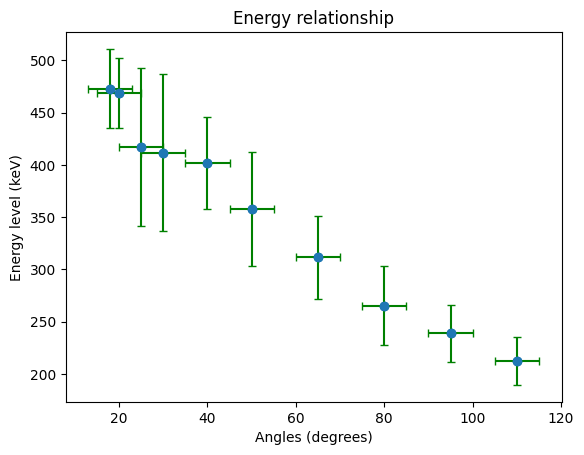

In [22]:
plt.scatter(angles, E)
#plt.plot(angles, compton(np.array(angles), *fit_coeff))
plt.errorbar(angles, E, xerr = 5, yerr = sigma_E, fmt = 'o', ecolor = 'g', capsize=3 )

# Add axis labels and title
plt.xlabel('Angles (degrees)')
plt.ylabel('Energy level (keV)')
plt.title('Energy relationship')

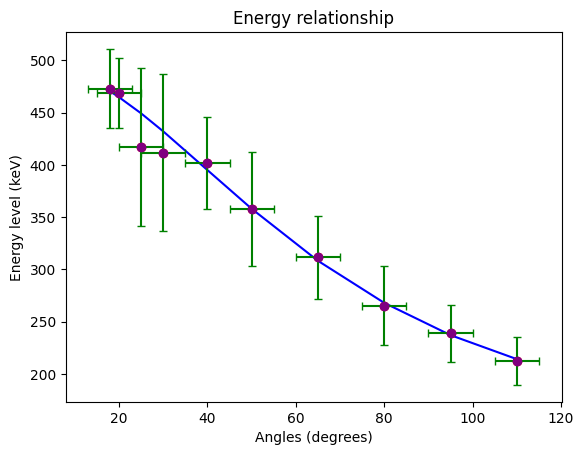

In [23]:
# Plot the data with scatter points in red color
plt.scatter(angles, E, color='red')

# Plot the fitted curve in blue color
plt.plot(angles, compton(np.array(angles), *fit_coeff), color='blue')

# Plot the errorbars with x error in violet color and y error in green color
plt.errorbar(angles, E, xerr=5, yerr=sigma_E, fmt='o', ecolor='green', capsize=3, color='purple')

# Add axis labels and title
plt.xlabel('Angles (degrees)')
plt.ylabel('Energy level (keV)')
plt.title('Energy relationship')

# Show the plot
plt.show()







Text(0, 0.5, 'Counts')

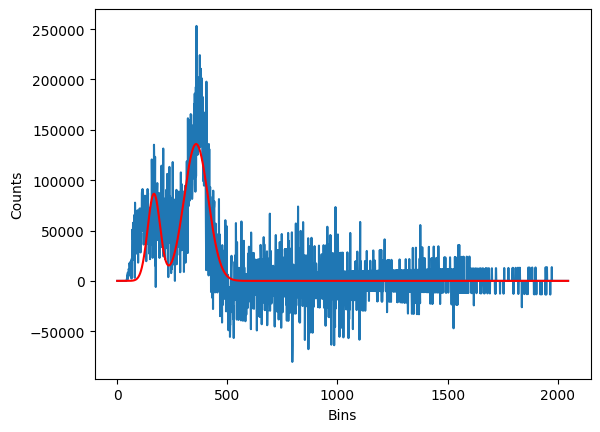

In [24]:
plt.plot(np.arange(2048), data[5])
plt.plot(np.arange(2048), fit_func(np.arange(2048), *coefficients[5]), 'r-')
plt.xlabel('Bins')
plt.ylabel('Counts')

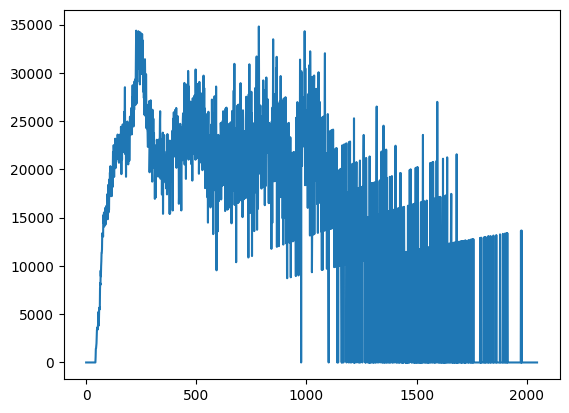

In [25]:
plt.plot(range(len(sigmas[8])), sigmas[8])

In [26]:
################################################### PART 3 ############################################################

N_e = (np.pi*(0.065/2)**2*0.172*2710/4.48E-26)*13
N_g = (1.11E7)*(0.5)**(45/30)
d_O = 1
#(0.085)**2/(4*0.1524**2)
print(N_e, N_g, d_O)

4.488277192268038e+26 3924442.635585339 1


In [27]:
sigma_peak = [round(coefficients[i][3]) for i in range(len(data))]
peak_loc = [round(element) for element in E]
count_bins = [(int(peak_loc[i] - 2*sigma_peak[i]), int(peak_loc[i] + 2*sigma_peak[i])) for i in range(len(peak_loc))]
n_bins = [count_bins[i][1] - count_bins[i][0] for i in range(len(count_bins))]
counts = [np.sum(data[i][count_bins[i][0]:count_bins[i][1]]) for i in range(len(count_bins))]
print(count_bins)
print(n_bins)

[(397, 549), (401, 537), (265, 569), (262, 562), (314, 490), (248, 468), (231, 391), (189, 341), (185, 293), (167, 259)]
[152, 136, 304, 300, 176, 220, 160, 152, 108, 92]


<ErrorbarContainer object of 3 artists>

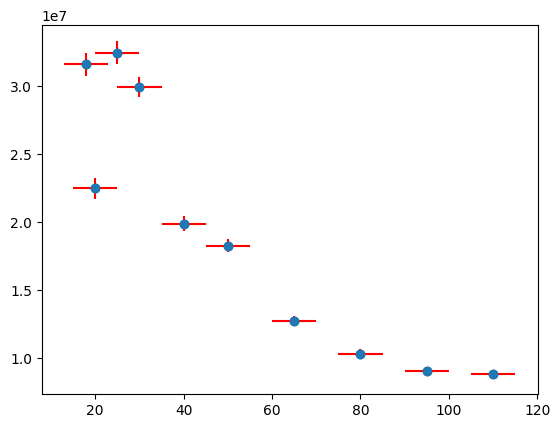

In [28]:
errors = [np.sum(sigmas[i][count_bins[i][0]:count_bins[i][1]]**2)**0.5 for i in range(len(count_bins))]
plt.scatter(angles, counts)
plt.errorbar(angles, counts, xerr = 5, yerr = errors, fmt = 'o', ecolor = 'r' )

In [29]:
# Calculate differential scattering cross-section
const = 3000
cross_section = np.array(counts)/(N_e*N_g*d_O*const)
print(cross_section)
errors_cs = [errors[i]/(N_e*N_g*d_O*const) for i in range(len(data))]
errors_cs = 10*np.array(errors_cs)

[5.98706538e-30 4.25799951e-30 6.14780492e-30 5.67081873e-30
 3.76817292e-30 3.46067146e-30 2.40797351e-30 1.95741464e-30
 1.70923304e-30 1.67640421e-30]


In [30]:
# Define the K-N equation
def KN(x):
  x = np.pi*x/180
  r = 2.82E-15
  y = 662/511
  return ((r**2/2)*(1 + np.cos(x)**2)/(1 + y*(1 - np.cos(x)))**2)*(1 + y**2*(1 - np.cos(x))**2/((1 + np.cos(x)**2)*(1 + y*(1-np.cos(x)))))

# Define Thompson equation
def Thompson(x):
  r = 2.82E-15
  return r**2/2*(1+np.cos(np.pi*x/180)**2)

<ErrorbarContainer object of 3 artists>

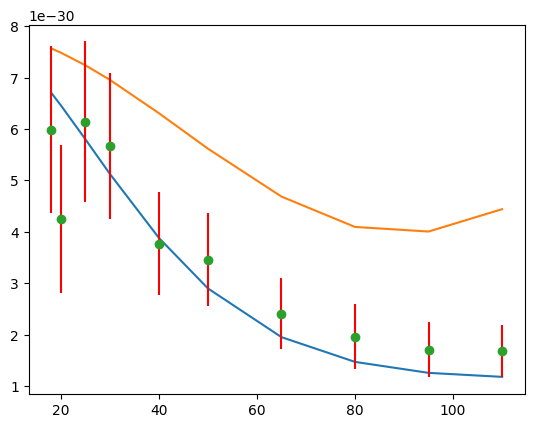

In [31]:
plt.plot(angles, KN(np.array(angles)))
plt.plot(angles, Thompson(angles))
#plt.plot(angles, cross_section)
plt.errorbar(angles, cross_section, yerr = np.array(errors_cs), fmt = 'o', ecolor = 'r')

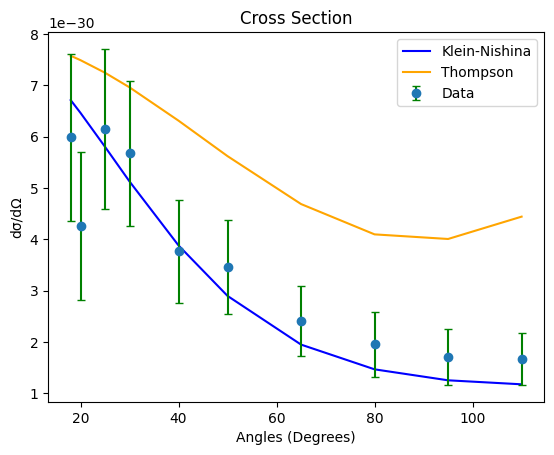

In [32]:

# Plot the Klein-Nishina model in blue color and the Thompson model in orange color
plt.plot(angles, KN(np.array(angles)), color='blue', label='Klein-Nishina')
plt.plot(angles, Thompson(angles), color='orange', label='Thompson')

# Plot the data with error bars in green color
plt.errorbar(angles, cross_section, yerr=np.array(errors_cs), fmt='o', ecolor='green', capsize=3, label='Data')

# Add x axis error bars
#plt.xlim([0, 100])
#plt.fill_between([0, 5], 0, max(cross_section), alpha=0.2, color='gray')
#plt.fill_between([55, 60], 0, max(cross_section), alpha=0.2, color='gray')

# Add axis labels and title
plt.xlabel('Angles (Degrees)')
plt.ylabel('dσ/dΩ')
plt.title('Cross Section')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [33]:
# X^2 test
def chi(X,Y,sigmas, func):
  return np.sum((Y - func(X))**2/sigmas**2)

In [34]:
thompson_chi = chi(angles, cross_section, errors_cs, Thompson)
KN_chi = chi(angles, cross_section, errors_cs, KN)
print(thompson_chi)
print(KN_chi)

89.20571903586466
5.825751390541714


In [35]:
################################ PART 4 ##################################

os.chdir("/content/gdrive/MyDrive/PHY 445/Data/Part-4/")
Cu_25 = extract_data("part4_25_small_Cu_yes_scatter.Txt")
Cu_45 = extract_data("part4_45_small_Cu_yes_scatter.Txt")
Al_25 = extract_data("part4_25_small_Al_yes_scatter.Txt")
Al_45 = extract_data("part4_45_small_Al_yes_scatter.Txt")

window_size = 75

def transform(x):
  return np.exp(x)

def inv_transform(x):
  return np.log(x)

part_4_dat = [(Cu_25 - back_data[2])/epsilon, (Cu_45 - back_data[4])/epsilon, (Al_25 - back_data[2])/epsilon, (Al_45 - back_data[4])/epsilon]
var = [(Cu_25 + back_data[2])/epsilon**2, (Cu_45 + back_data[4])/epsilon**2, (Al_25 + back_data[2])/epsilon**2, (Al_45 + back_data[4])/epsilon**2]

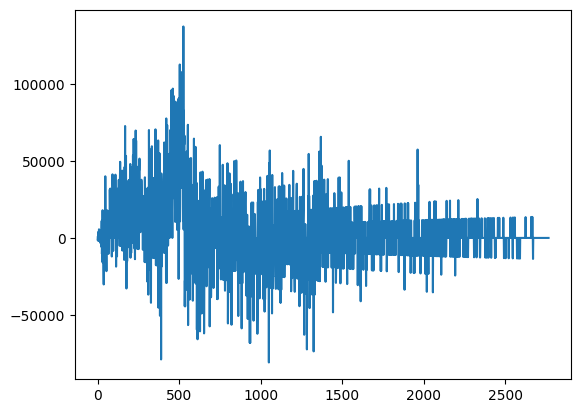

In [36]:
plt.plot(B_E(np.arange(2048)), part_4_dat[1])

In [37]:
#Remove NaNs from data
for i in range(len(part_4_dat)):
  part_4_dat[i][np.isnan(part_4_dat[i])] = 1
  var[i][np.isnan(var[i])] = 1

In [38]:
def moving_average(numbers, window_size):
    """
    Computes the moving average of a list of numbers using a sliding window of
    a given size.

    :param numbers: A list of numbers to compute the moving average of.
    :param window_size: The size of the sliding window to use.
    :return: A list containing the moving averages.
    """
    moving_averages = []
    for i in range(len(numbers) - window_size + 1):
        window = numbers[i:i+window_size]
        average = sum(window) / window_size
        moving_averages.append(average)
    return np.array(moving_averages)

In [39]:
# Compute moving average
ma_dat=[moving_average(part_4_dat[i], window_size = window_size) for i in range(len(part_4_dat))]
ma_sig = [(moving_average(var[i], window_size = window_size)/window_size)**0.5 for i in range(len(var))]

In [40]:
def func(x, a0,a1,a2,mu,std,h):
  return poly(x, a0,a1,a2) + gaussian(x, mu,std,h)

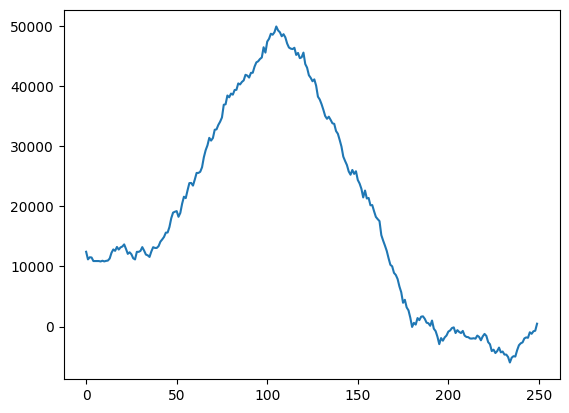

In [41]:
d = ma_dat[1][250:500]
plt.plot(range(len(d)), d)

In [42]:
# Define approximate location of peaks
peaks = [(340,500), (250,500), (350,600), (270,450)]
dat = [ma_dat[i][peaks[i][0]:peaks[i][1]] for i in range(len(peaks))]
sig = [ma_sig[i][peaks[i][0]:peaks[i][1]] for i in range(len(peaks))]
loc = [(tup[1] - tup[0])/2 for tup in peaks]

In [43]:
consts = []
covs = []
for i in range(len(dat)):
  popt, pcov = scipy.optimize.curve_fit(func, np.arange(len(dat[i])), dat[i], p0 = [0,0,0, loc[i], loc[i]/2, 3E4])
  consts.append(popt)
  covs.append(pcov)

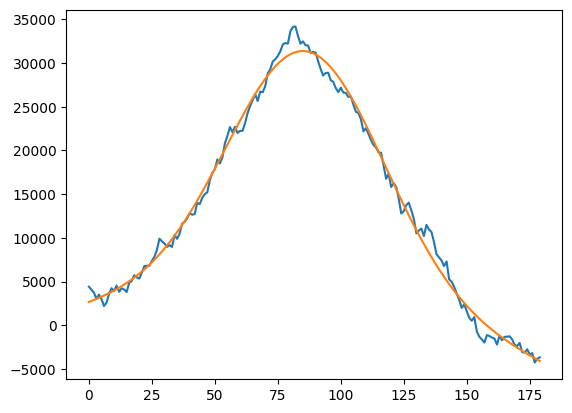

In [44]:
i = 3
d = dat[i]
plt.plot(range(len(d)), d)
plt.plot(range(len(d)), func(np.arange(len(d)), *consts[i]))

In [45]:
# Calculate number of counts after subtraction of polynomial
poly_coeff = [(const[0], const[1], const[2]) for const in consts]
dat = [dat[i] - poly(np.arange(len(dat[i])), *poly_coeff[i]) for i in range(len(dat))]

stds = [const[4] for const in consts]
mus = [const[3] for const in consts]
bins = [(int(mus[i] - stds[i]), int(mus[i] + stds[i])) for i in range(len(mus))]
counts_sum = []
counts_std = []

for i in range(len(mus)):
  counts_sum.append(np.sum(dat[i][bins[i][0]:bins[i][1]]))
  counts_std.append(np.sum(dat[i][bins[i][0]:bins[i][1]]**2)**0.5)

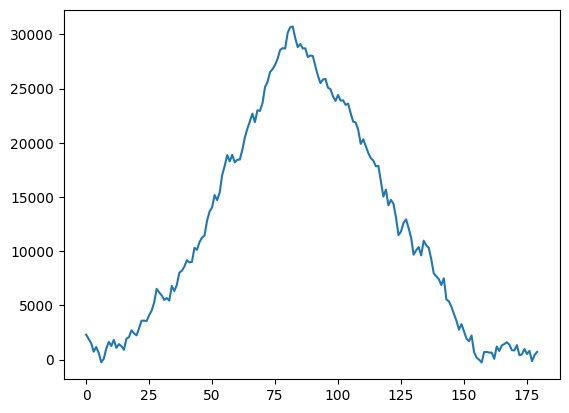

In [46]:
i = 3
d = dat[i]
plt.plot(range(len(d)), d)

<ErrorbarContainer object of 3 artists>

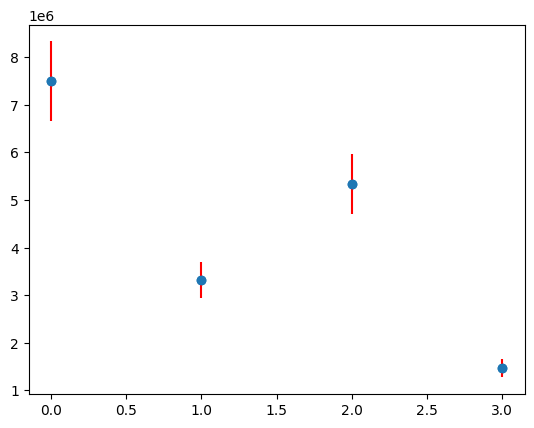

In [47]:
plt.scatter(range(len(counts_sum)), counts_sum)
plt.errorbar(range(len(counts_sum)), counts_sum, yerr = counts_std, fmt = 'o', ecolor = 'r')

[0.711755781367065, 0.4399517557314536]
[0.11590947902955263, 0.07610817561321176]


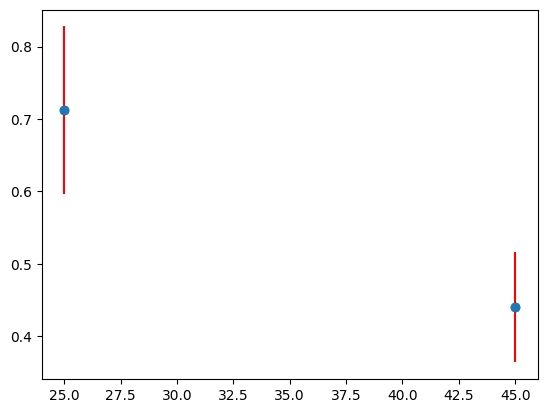

In [48]:
# Calculate ratio of electrons
thetas = [25,45]
MACs = [0.068, 0.074] #[Cu MAC, Al MAC]
ratios = [counts_sum[2]/counts_sum[0], counts_sum[3]/counts_sum[1]]
errs = [(counts_sum[2]/counts_sum[0])*(counts_std[2]**2/counts_sum[2]**2 + counts_std[0]**2/counts_sum[0]**2)**0.5, (counts_sum[3]/counts_sum[1])*(counts_std[3]**2/counts_sum[3]**2 + counts_std[1]**2/counts_sum[1]**2)**0.5]
plt.scatter(thetas, ratios)
plt.errorbar(thetas, ratios, yerr = errs,fmt = 'o', ecolor = 'r')
print(ratios)
print(errs)